In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [2]:
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans

In [3]:
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
warnings.filterwarnings('ignore')

In [230]:
%load_ext autoreload
%autoreload 2
from notebook_functions import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Read in Data and Prepare Variables

In [7]:
strateos_sample = pd.read_csv("experiment_data/processed/final_strateos_sample.csv")

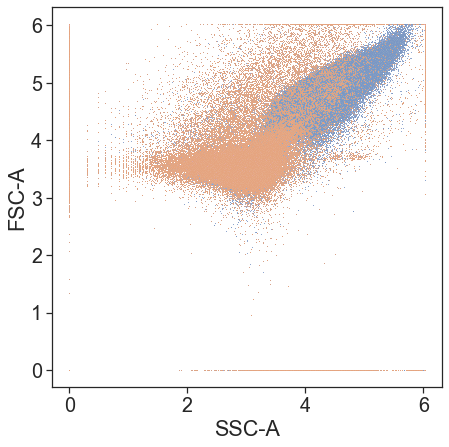

In [225]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=strateos_sample, x="SSC-A", y="FSC-A", s=1)
sns.scatterplot(data=strateos_sample.loc[strateos_sample[n.inducer_concentration] == 80.0],
                x="SSC-A", y="FSC-A", s=1)

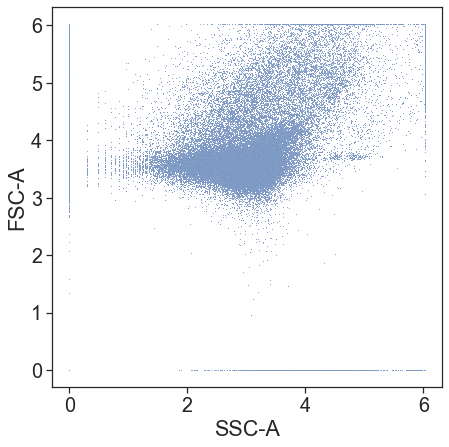

In [224]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=strateos_sample.loc[strateos_sample[n.inducer_concentration] == 80.0],
                x="SSC-A", y="FSC-A", s=1)

In [8]:
strateos_stained = strateos_sample.loc[strateos_sample["stain"] == 1]
strateos_unstained = strateos_sample.loc[strateos_sample["stain"] == 0]

In [9]:
features_unstained = n.morph_cols
features_stained_strateos = n.morph_cols + ["RL1-A", "RL1-H", "RL1-W"]

In [10]:
print(features_unstained)
print(features_stained_strateos)

['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']
['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'RL1-A', 'RL1-H', 'RL1-W']


In [11]:
strateos_stained

,stain,inducer_concentration,timepoint,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,RL1-A,RL1-H,RL1-W,BL1-A,BL1-H,BL1-W,percent_live,source
405000,1,0.0,0.5,5.025396,4.909829,1.653213,4.694781,4.554477,1.556303,1.278754,2.130334,0.0,0.000000,1.579784,0.0,98.776667,strateos
405001,1,0.0,0.5,4.902123,4.802822,1.612784,4.632214,4.491474,1.531479,0.477121,2.120574,0.0,1.799341,1.785330,0.0,98.776667,strateos
405002,1,0.0,0.5,5.250283,4.892784,1.919078,4.977938,4.585133,1.826075,2.292256,2.252853,0.0,0.000000,1.869232,0.0,98.776667,strateos
405003,1,0.0,0.5,5.001284,4.810011,1.662758,4.677525,4.501812,1.568202,0.000000,2.037426,0.0,1.986772,1.991226,0.0,98.776667,strateos
405004,1,0.0,0.5,4.865702,4.775749,1.602060,4.513697,4.420022,1.477121,0.000000,1.568202,0.0,2.017033,1.690196,0.0,98.776667,strateos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809995,1,80.0,6.0,4.256164,3.546172,0.000000,0.000000,2.257679,0.000000,0.000000,1.763428,0.0,1.949390,1.755875,0.0,0.000000,strateos
809996,1,80.0,6.0,3.509337,3.339451,0.000000,0.301030,2.887617,0.000000,0.000000,2.012837,0.0,1.414973,1.908485,0.0,0.000000,strateos
809997,1,80.0,6.0,4.814527,3.656098,0.000000,0.000000,2.747412,0.000000,2.654177,2.158362,0.0,2.357935,2.012837,0.0,0.000000,strateos
809998,1,80.0,6.0,3.364176,3.334051,0.000000,3.061075,3.186674,0.000000,2.133539,2.416641,0.0,0.000000,1.770852,0.0,0.000000,strateos


# Generate RF Labels for Stained data but only using Morph Features

In [12]:
df_strateos_stained_morph, \
X_strateos_stained_morph, \
Y_strateos_stained_morph = generate_rf_labels_from_conditions(strateos_stained,
                                                              features_unstained,
                                                              )

Conditions designated as Live: [{'inducer_concentration': 0.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'inducer_concentration': 20.0, 'timepoint': 6.0}, {'inducer_concentration': 80.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 15:24:54
Starting Classification training...
Training time was: 22.50 seconds
Testing time was: 2.43 seconds
Prediction time of untested data was: 14.972217082977295
Run finished at 15:25:42. Total run time = 47.48 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




# All Plots/Models use Stained data, but models only use morph features

**Replacing CFU percent_live values for 0% ethanol at time 0.5 and 1.0 with 100% before feeding into the model**

In [13]:
Y_strateos_stained_morph.loc[(Y_strateos_stained_morph[n.inducer_concentration] == 0.0) & 
                             (Y_strateos_stained_morph[n.timepoint].isin([0.5, 1.0, 5.0])), n.percent_live] = 100.0
# Y_strateos_stained_morph


Model Boosting took 173.59228491783142 seconds
Training Accuracy = 92.48%
Counter({0: 256903, 1: 148097})
Instructions for updating:
Please use `model.predict()` instead.


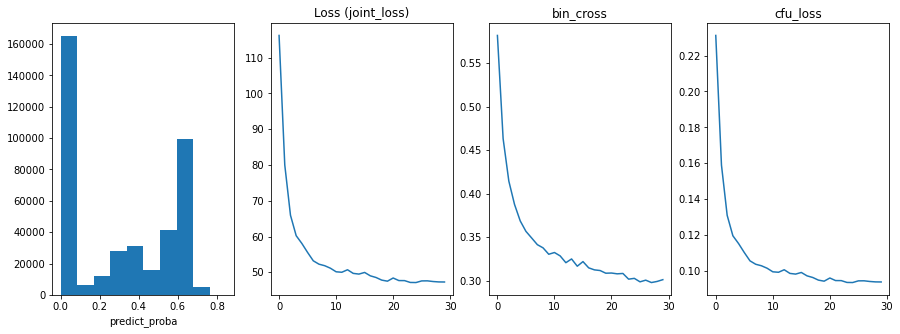

In [14]:
cr_strateos_stained_morph, \
pl_strateos_stained_morph = run_model(model_function=booster_model_v2, lr=0.001,
                                      loss = joint_loss_wrapper(500), metrics = [bin_cross, cfu_loss],
                                      X = X_strateos_stained_morph, Y = Y_strateos_stained_morph, 
                                      epochs = 30, batch_size = 2048,
                                      verbose = False, shuffle = True, plot_type="line")

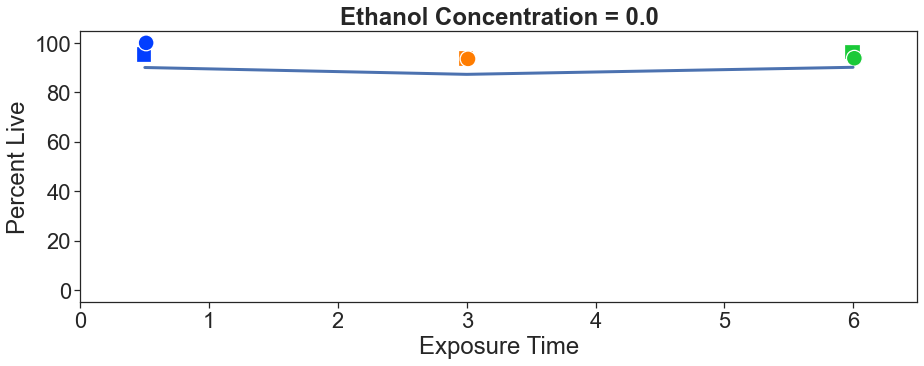

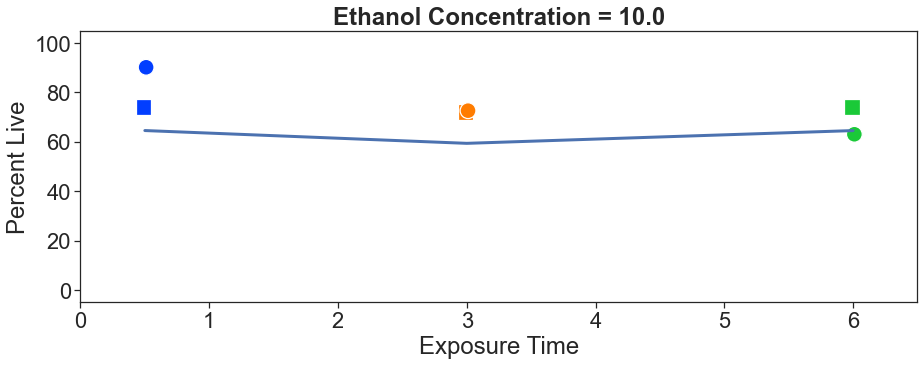

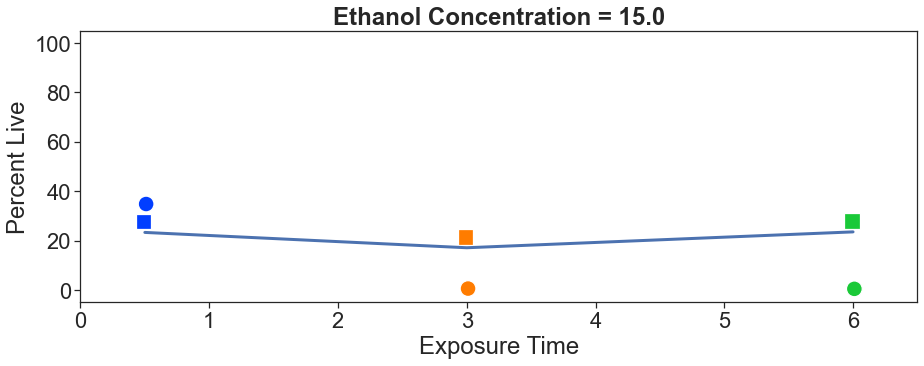

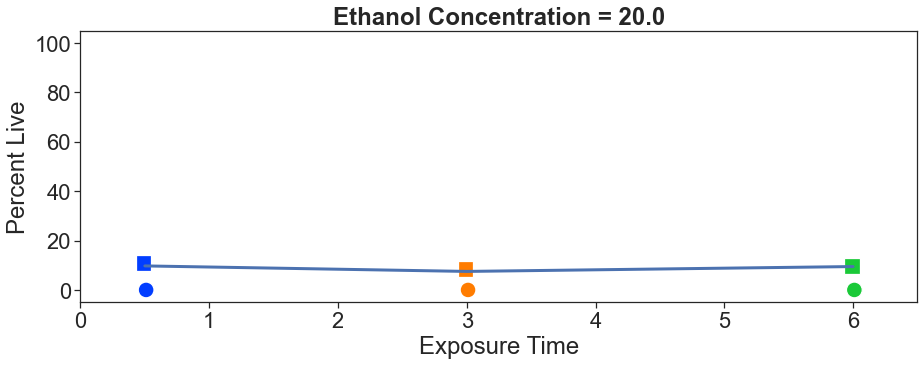

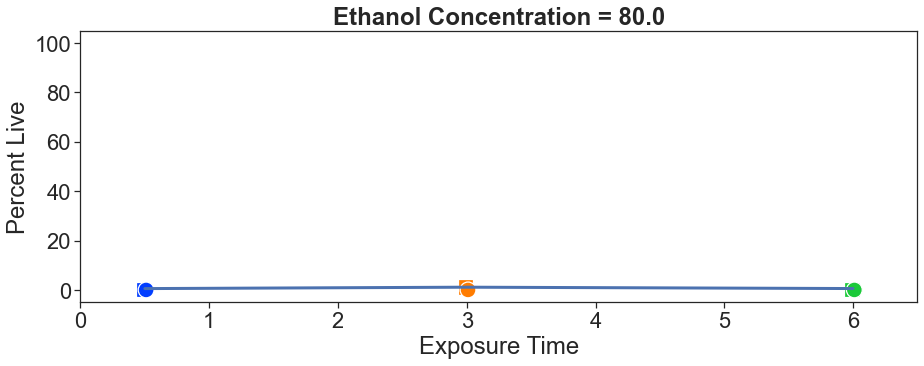

In [15]:
plot_per_cond(cr_strateos_stained_morph)

In [16]:
info_strateos_stained_morph = get_all_run_info(df_strateos_stained_morph, 
                                               X_strateos_stained_morph,
                                               pl_strateos_stained_morph,
                                               append_df_cols=["RL1-A", "RL1-H", "RL1-W"])

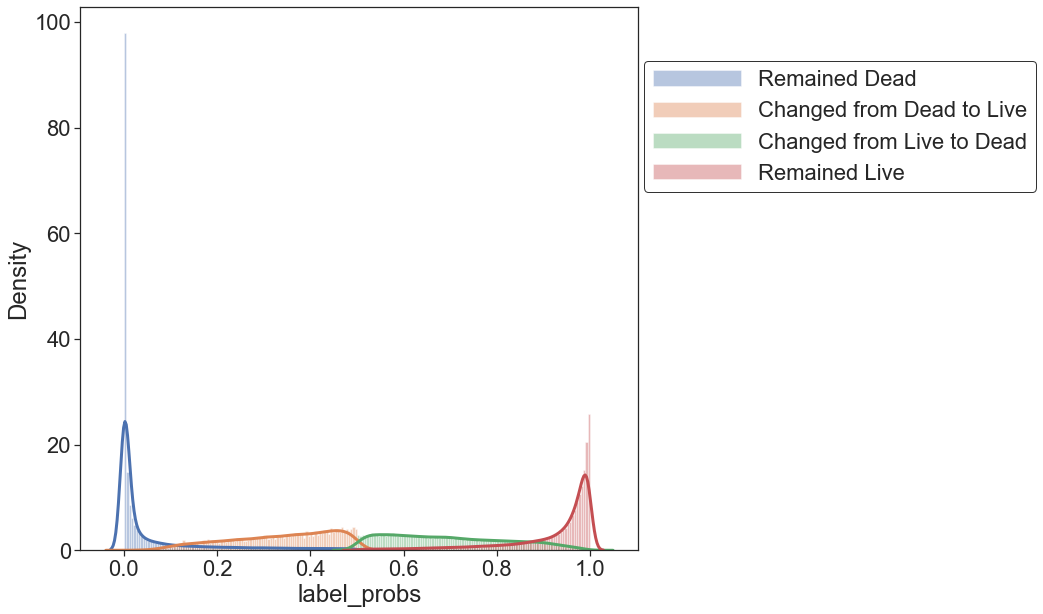

In [17]:
plot_prob_changes(info_strateos_stained_morph, None)

# Calculate KDEs to get point density

In [20]:
conc_df_all = get_conc_df_with_kde_values(info_strateos_stained_morph,
                                          conc="all",
                                          features=features_stained_strateos,
                                          cc="RL1-H")

# Set Variables

In [210]:
point_1_that_defines_line=(2.4, 4)
point_2_that_defines_line=(3.05, 5.75)

# Scatter + KDE Plots

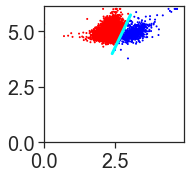

Percent of AutoGater live predictions that are left of the SOA dashed line: 92.48


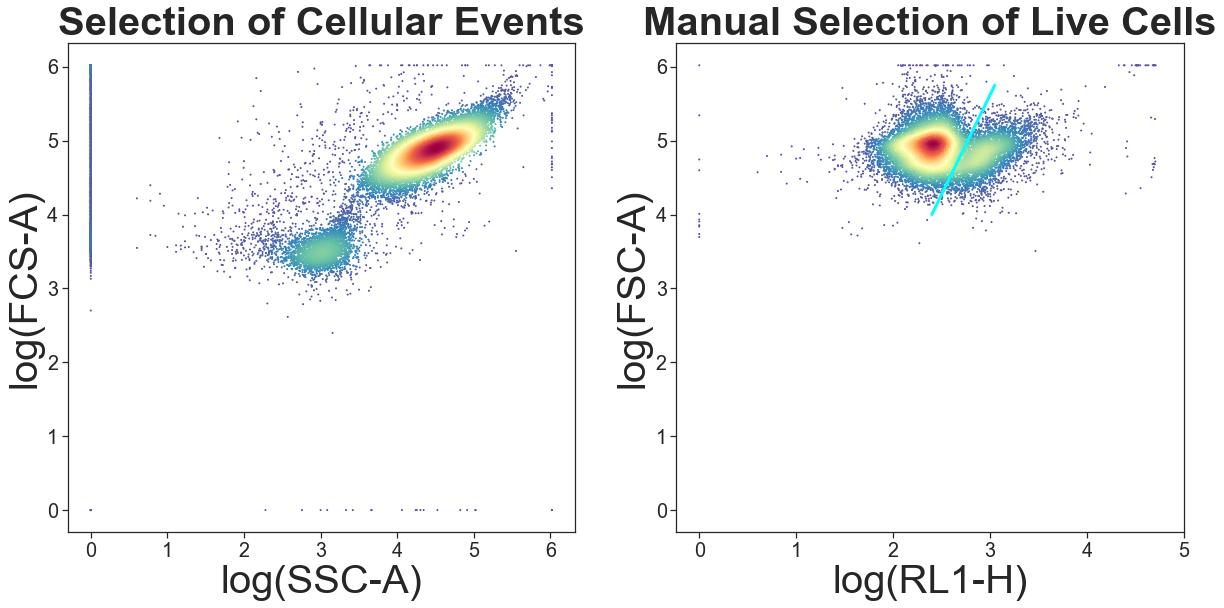

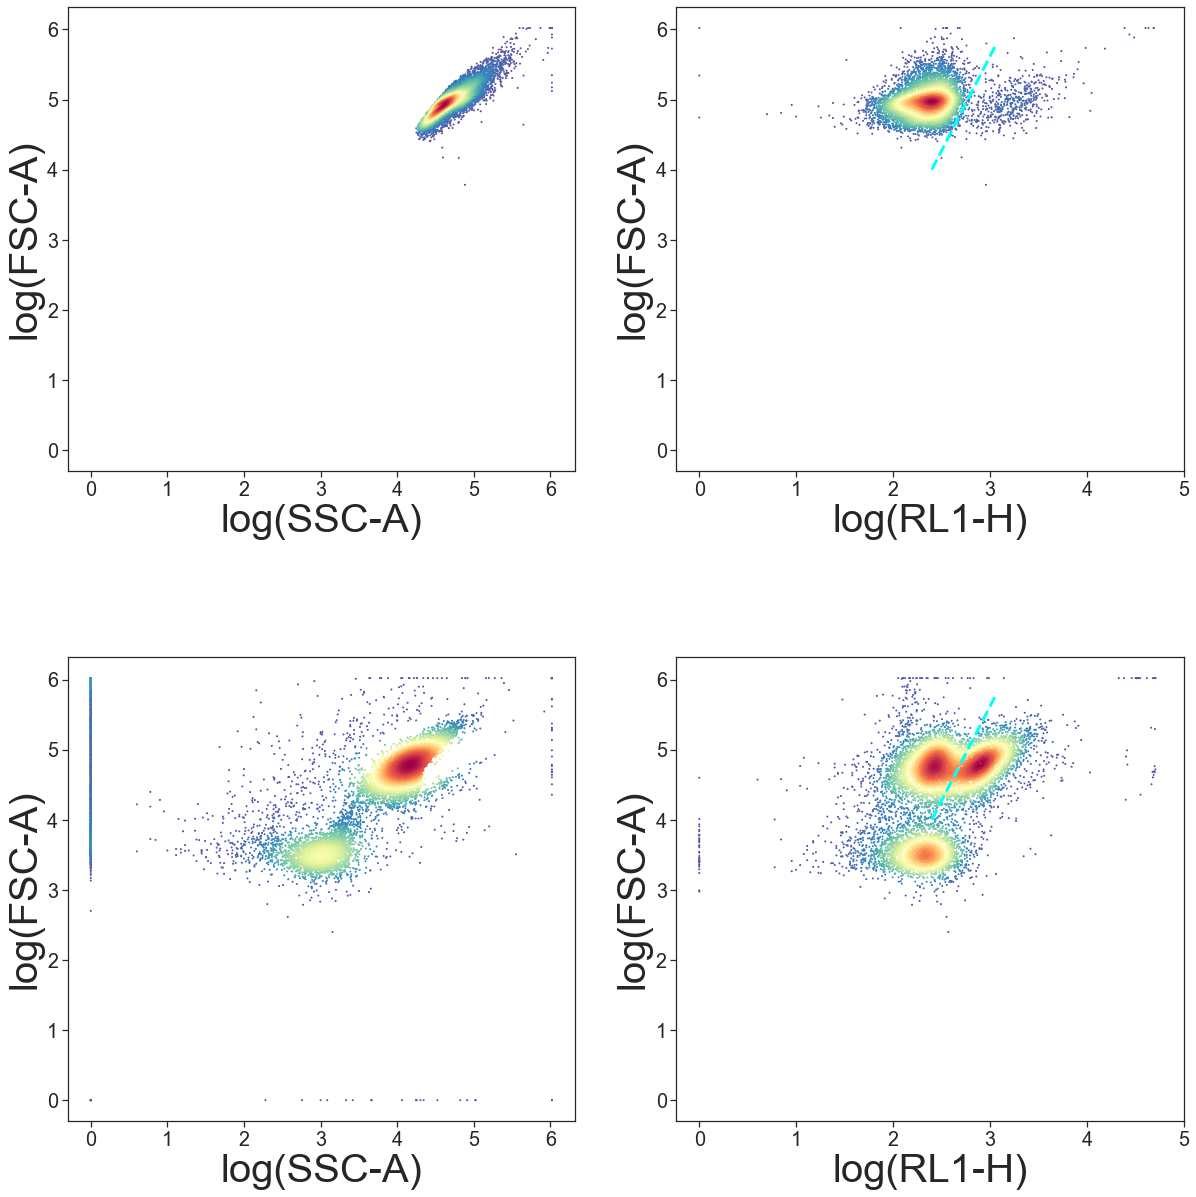

In [228]:
%matplotlib inline
kde_df = kde_scatter(conc_df_all, cc="RL1-H", logged=True,
                     fraction_of_points_based_on_kde=0.9,
                     point_1_that_defines_line=point_1_that_defines_line, 
                     point_2_that_defines_line=point_2_that_defines_line,
                     cmap="Spectral_r", pred_col="nn_preds")

## Summary Table and Plots

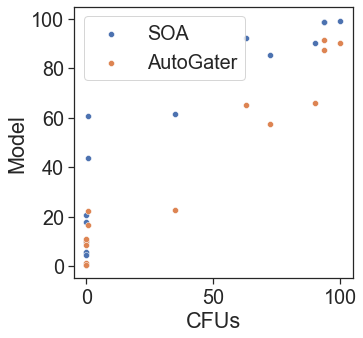

R-Squared between CFUs and State of the Art: 0.6196934908640976
R-Squared between CFUs and AutoGater: 0.8775825546674981



In [233]:
%matplotlib inline
summary_table = summary_table_of_results(kde_df)

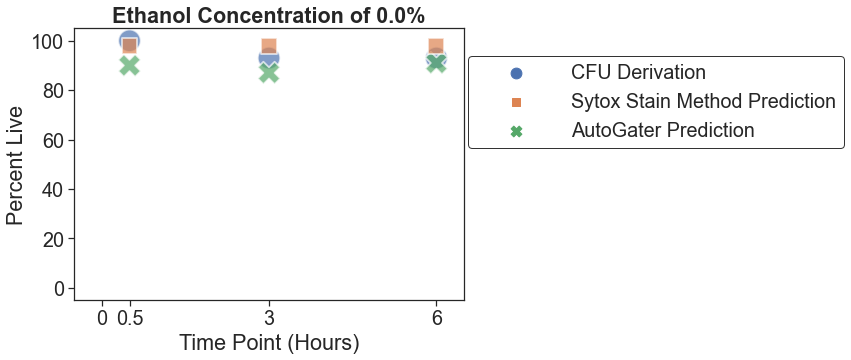

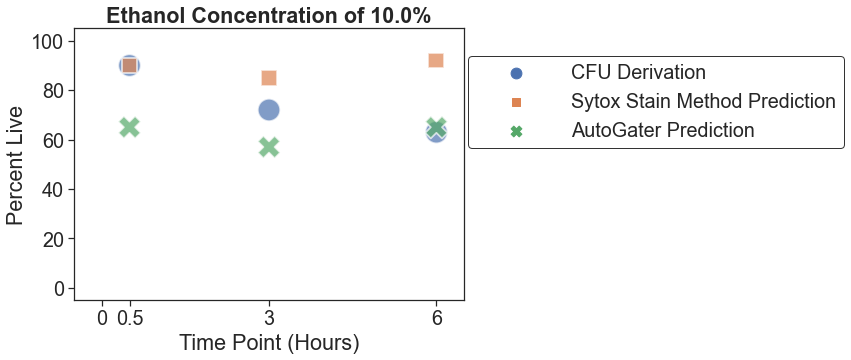

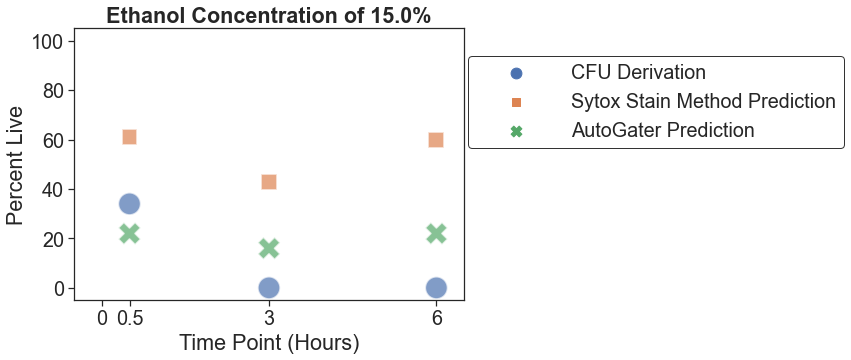

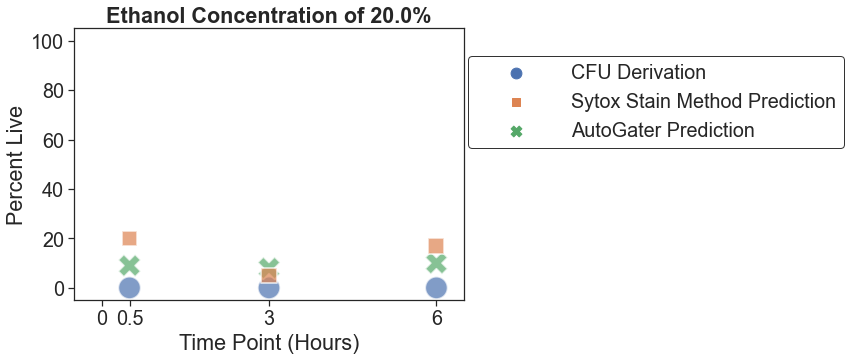

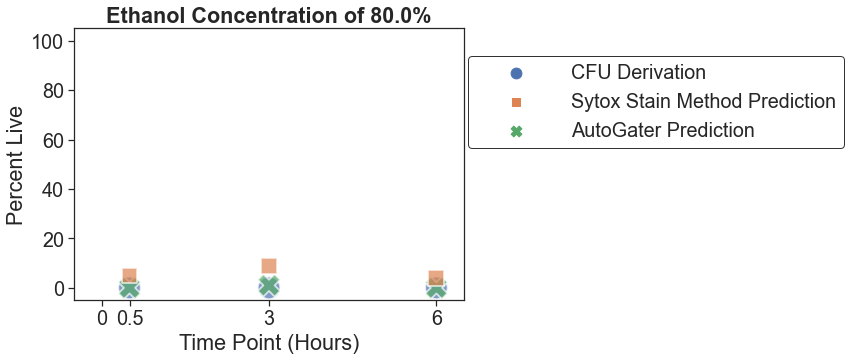

In [234]:
%matplotlib inline
percent_live_comparison_plot(summary_table)